In [38]:
!pip install tensorflowjs

In [39]:
import tensorflow as tf
# print(tf.__version__)


In [40]:
import kagglehub
import os
import shutil
# Download latest version
path = kagglehub.dataset_download("imsparsh/flowers-dataset")

print("Path to dataset files:", path)
# Copiar recursivamente todas las carpetas y archivos de 'path' a 'dataset' sin función recursiva
if not os.path.exists("dataset"):
    os.makedirs("dataset")
for root, dirs, files in os.walk(path):
    # Construir la ruta de destino correspondiente
    dest_dir = os.path.join("dataset", os.path.relpath(root, path))
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    for file in files:
        src_file = os.path.join(root, file)
        dst_file = os.path.join(dest_dir, file)
        shutil.copy2(src_file, dst_file)


Path to dataset files: /kaggle/input/flowers-dataset


In [41]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np

# Tus datos originales
celsius = np.array([-40, -10, 0, 8, 15, 22, 38], dtype=float)
fahrenheit = np.array([-40, 14, 32, 46, 59, 72, 100], dtype=float)

# 1. Divide en 80% train y 20% test
celsius_train, celsius_test, fahrenheit_train, fahrenheit_test = train_test_split(
    celsius, fahrenheit, test_size=0.2, random_state=42
)

# 2. Reserva 5% del train para validación
celsius_train_final, celsius_val, fahrenheit_train_final, fahrenheit_val = train_test_split(
    celsius_train, fahrenheit_train, test_size=0.05, random_state=42
)

print("Train:", celsius_train_final)
print("Validation:", celsius_val)
print("Test:", celsius_test)

# Métrica personalizada: porcentaje de predicciones con error absoluto < 2 grados
def regression_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) < 2.0, tf.float32))

oculta1 = tf.keras.layers.Dense(units=3, input_shape=[1])
oculta2 = tf.keras.layers.Dense(units=3)
salida = tf.keras.layers.Dense(units=1)
modelo = tf.keras.Sequential([oculta1, oculta2, salida])

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(0.01),
    loss='mean_squared_error',
    metrics=[regression_accuracy]
)

print("Comenzando entrenamiento...")
history = modelo.fit(celsius_train_final, fahrenheit_train_final,epochs=300,
                     verbose=False,validation_data=(celsius_val, fahrenheit_val))
print("Modelo entrenado!")

Train: [38. 15. 22.  8.]
Validation: [0.]
Test: [-40. -10.]
Comenzando entrenamiento...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modelo entrenado!


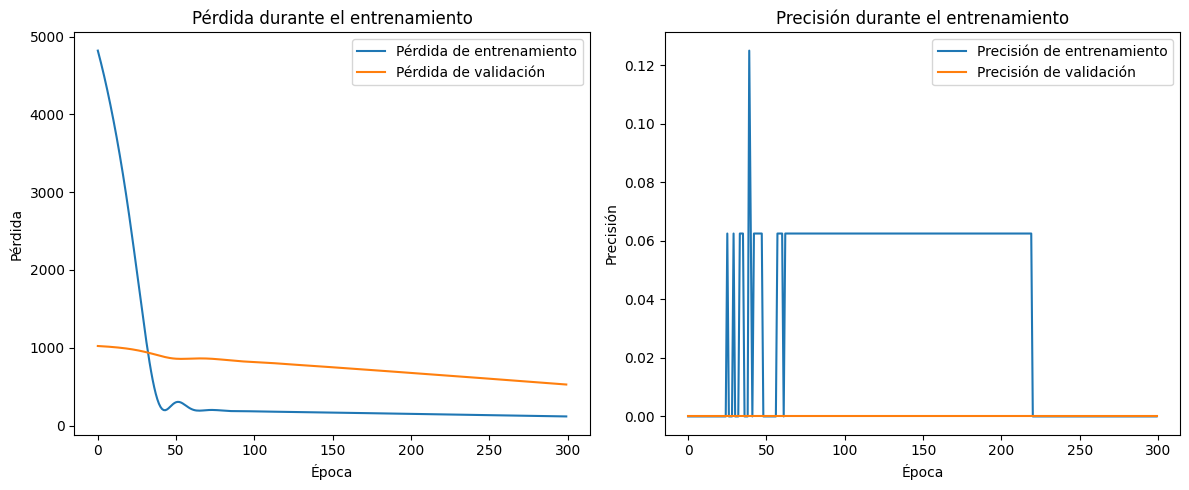

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Gráfica de pérdida (loss)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Gráfica de precisión (accuracy)
plt.subplot(1, 2, 2)
plt.plot(history.history['regression_accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_regression_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
resultado = modelo.predict(np.array([100.0])) # Convert the list to a NumPy array
print("Prediccion: 100 grados celsius son " + str(resultado) + " fahrenheit!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Prediccion: 100 grados celsius son [[276.4766]] fahrenheit!


In [44]:
import pandas as pd

# Generar 1000 temperaturas Celsius entre -100 y 100
celsius_values = np.linspace(-100, 100, 1000)
# Usar el modelo entrenado para predecir Fahrenheit
fahrenheit_pred = modelo.predict(celsius_values).flatten()

# Crear DataFrame
df_temp = pd.DataFrame({
    'Celsius': celsius_values,
    'Fahrenheit': fahrenheit_pred
})

# Guardar a CSV
df_temp.to_csv('temperaturas_convertidas.csv', index=False)
print("Archivo 'temperaturas_convertidas.csv' generado con 1000 temperaturas.")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Archivo 'temperaturas_convertidas.csv' generado con 1000 temperaturas.


In [45]:
#Exportar el modelo en formato h5
modelo.save('celsius_a_fahrenheit.h5')

In [46]:
import subprocess
subprocess.run(["mkdir", "carpeta_salida"])
#Convertir el modelo a tensorflow.js
subprocess.run(["tensorflowjs_converter", "--input_format", "keras", "celsius_a_fahrenheit.h5", "carpeta_salida"])

CompletedProcess(args=['tensorflowjs_converter', '--input_format', 'keras', 'celsius_a_fahrenheit.h5', 'carpeta_salida'], returncode=0)

In [47]:
#Confirmar que en la carpeta de salida se hayan generado los archivos. Deben aparecer archivos "bin" y "json"
# !ls carpeta_salida

NameError: name 'class_names' is not defined

In [ ]:
import tensorflow as tf

IMG_WIDTH = 180
IMG_HEIGHT = 180
BATCH_SIZE = 32

# Cargar datasets desde la carpeta 'dataset/'
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Obtener nombres de las clases
class_names = train_ds.class_names
print(class_names)

# Configurar datasets para rendimiento
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Definir el modelo CNN
num_classes = len(class_names)
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Entrenar el modelo
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

# Exportar el modelo
model.save('flower_classifier.h5')

# Convertir el modelo a formato TensorFlow.js
import subprocess
subprocess.run(["mkdir", "flower_classifier_tfjs"])
subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "keras",
    "flower_classifier.h5",
    "flower_classifier_tfjs"
])

# You can then download the `flower_classifier_tfjs` folder and use it in a web application.
# The web application will need to load the TensorFlow.js model and perform inference on selected images.
# The class names (`class_names`) will also be needed in the web application to display the predicted flower name.


Found 3670 files belonging to 2 classes.
Using 2936 files for training.
Found 3670 files belonging to 2 classes.
Using 734 files for validation.
['test', 'train']
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6856 - loss: 0.6661 - val_accuracy: 0.7439 - val_loss: 0.5673
Epoch 2/10
